# Multilayer Perceptron (MLP) 
(c) Deniz Yuret, 2019
* Objectives: Stack multiple layers, demonstrate the power of nonlinear activation functions, use regularization and dropout to address overfitting.
* Prerequisites: [Linear models](30.lin.ipynb), [MNIST](20.mnist.ipynb)
* New functions: 
[relu](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.relu), 
[dropout](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.dropout), 
[param, param0](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.param), 
[xavier](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.xavier), 
[training](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.training), 
[gc](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.gc)

![image](https://github.com/denizyuret/Knet.jl/blob/master/docs/src/images/neural_net2.jpeg?raw=true)
([image source](http://cs231n.github.io/neural-networks-1))

A multilayer perceptron, i.e. a fully connected feed-forward neural network, is basically a bunch of linear layers stuck together with non-linearities in between. In this notebook we will first chain together a couple of linear layers and see that it has no effect on performance (multiple linear layers still compute a linear function). However with a one line change (adding an elementwise nonlinear function between layers) the accuracy will go from 92% to 98%! It turns out the class of functions that can be represented by linear models is severely restricted and does not contain good MNIST classifiers. MLPs have no such restrictions, being **universal function approximators** they can represent any classifier given large enough layers and learn the correct classifier with sufficient data. 

Simple models with low capacity, e.g. the linear model, have an **underfitting** problem: the error does not drop to 0 even on the training set. Models with high capacity, e.g. MLP, have an **overfitting** problem: even when the training set error goes to 0, the test set error remains high. We will implement two methods to fight overfitting: **regularization** and **dropout**.

In [1]:
# Set display width, load packages, import symbols
ENV["COLUMNS"]=72
using Knet: Knet, dir, accuracy, progress, sgd, load143, save, gc, Param, KnetArray, Data, minibatch, nll, relu, training, dropout # param, param0, xavier_uniform
using Statistics: mean
using Base.Iterators: flatten
using IterTools: ncycle, takenth
using MLDatasets: MNIST
import CUDA # functional
array_type=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})

┌ Info: Precompiling Knet [1902f260-5fb4-5aff-8c31-6271790ab950]
└ @ Base loading.jl:1278


KnetArray{Float32,N} where N

In [2]:
# Load MNIST data
xtrn,ytrn = MNIST.traindata(Float32); ytrn[ytrn.==0] .= 10
xtst,ytst = MNIST.testdata(Float32);  ytst[ytst.==0] .= 10
dtrn = minibatch(xtrn, ytrn, 100; xsize = (784,:), xtype = array_type)
dtst = minibatch(xtst, ytst, 100; xsize = (784,:), xtype = array_type);

In [3]:
# For running experiments
function trainresults(file,model; o...)
    if (print("Train from scratch? "); readline()[1]=='y')
        r = ((model(dtrn), model(dtst), 1-accuracy(model,dtrn), 1-accuracy(model,dtst))
             for x in takenth(progress(sgd(model,ncycle(dtrn,100))),length(dtrn)))
        r = reshape(collect(Float32,flatten(r)),(4,:))
        Knet.save(file,"results",r)
        GC.gc(true) # To save gpu memory
    else
        isfile(file) || download("http://people.csail.mit.edu/deniz/models/tutorial/$file",file)
        r = Knet.load143(file,"results")
    end
    println(minimum(r,dims=2))
    return r
end

trainresults (generic function with 1 method)

In [4]:
# Some utilities to make model definitions easier:
param(d...; init=xavier_uniform, atype=array_type)=Param(atype(init(d...)))
param0(d...; atype=array_type)=param(d...; init=zeros, atype=atype)
xavier_uniform(o,i) = (s = sqrt(2/(i+o)); 2s .* rand(o,i) .- s)

xavier_uniform (generic function with 1 method)

## A generic multilayer model

In [5]:
# Let's define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = nll(c(x),y)
(c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)

## Multiple linear layers do not improve over a single linear layer

In [6]:
# Define a linear layer (See lin.ipynb):
struct Layer0; w; b; end
Layer0(i::Int,o::Int) = Layer0(param(o,i),param0(o))
(l::Layer0)(x) = (l.w * x .+ l.b)

In [7]:
# Here is an example two layer model
model=Chain(Layer0(784,64), Layer0(64,10))
println.(summary.((l.w,l.b)) for l in model.layers);

("64×784 Param{KnetArray{Float32,2}}", "64-element Param{KnetArray{Float32,1}}")
("10×64 Param{KnetArray{Float32,2}}", "10-element Param{KnetArray{Float32,1}}")


In [8]:
# Train the two layer model
# 2.04e-01  100.00%┣████████████████┫ 60000/60000 [00:51/00:51, 1179.52i/s]
# [0.240742; 0.282535; 0.0691333; 0.0794]
mlp1 = trainresults("mlp113a.jld2", model);

Train from scratch? stdin> y


┣████████████████████┫ [100.00%, 60000/60000, 01:46/01:46, 565.90i/s] 


Float32[0.24216889; 0.28485858; 0.06973334; 0.0797]


In [9]:
# Here is a single layer (linear) model
model=Chain(Layer0(784,10))
println.(summary.((l.w,l.b)) for l in model.layers);

("10×784 Param{KnetArray{Float32,2}}", "10-element Param{KnetArray{Float32,1}}")


In [10]:
# Train the single layer (linear) model
# 2.30e-01  100.00%┣████████████████┫ 60000/60000 [00:40/00:40, 1502.26i/s]
# [0.242363; 0.267073; 0.0671333; 0.0746]
lin1 = trainresults("mlp113b.jld2", model);

Train from scratch? stdin> n
Float32[0.24184321; 0.26703557; 0.066866666; 0.0747]


In [11]:
using Plots; default(fmt=:png,ls=:auto)

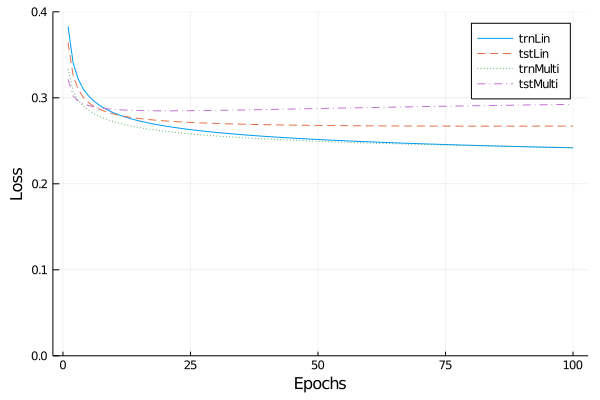

In [12]:
# multilinear converges to a similar solution, not identical because problem is non-convex
plot([lin1[1,:], lin1[2,:], mlp1[1,:], mlp1[2,:]], ylim=(0.0,0.4),
    labels=["trnLin" "tstLin" "trnMulti" "tstMulti"],xlabel="Epochs",ylabel="Loss")  

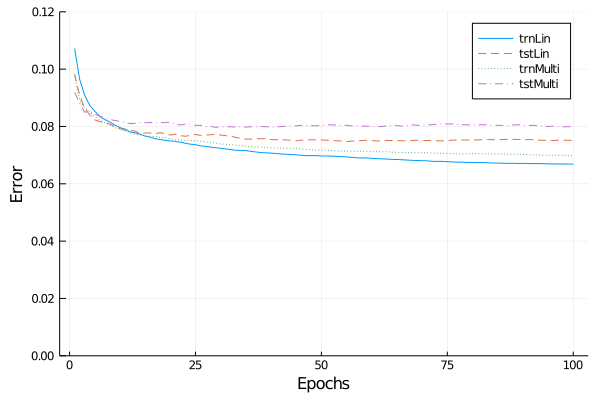

In [13]:
# error results also close to the linear model
plot([lin1[3,:], lin1[4,:], mlp1[3,:], mlp1[4,:]], ylim=(0.0,0.12),
    labels=["trnLin" "tstLin" "trnMulti" "tstMulti"], xlabel="Epochs", ylabel="Error")  

## Multiple linear layers are useless because they are equivalent to a single linear layer
If we write down what is being computed and do some algebra, we can show that what is being computed is still an affine function of the input, i.e. stacking multiple linear layers does not increase the representational capacity of the model:

\begin{align*}
\hat{p} &= \mbox{soft}(W_2 (W_1 x + b_1) + b_2) \\
&= \mbox{soft}((W_2 W_1)\, x + W_2 b_1 + b_2) \\
&= \mbox{soft}(W x + b)
\end{align*}

## Multi Layer Perceptron (MLP) adds non-linearities between layers

In [14]:
# Using nonlinearities between layers results in a model with higher capacity and helps underfitting
# relu(x)=max(0,x) is a popular function used for this purpose, it replaces all negative values with zeros.
struct Layer1; w; b; f; end
Layer1(i::Int,o::Int,f=relu) = Layer1(param(o,i),param0(o),f)
(l::Layer1)(x) = l.f.(l.w * x .+ l.b)

In [15]:
# We add a nonlinear activation function to all but the last layer
# 2.83e-02  100.00%┣████████████████┫ 60000/60000 [00:52/00:52, 1150.34i/s]
# [0.00636037; 0.084129; 0.000516667; 0.0243]
model = Chain(Layer1(784,64), Layer1(64,10,identity))
mlp2 = trainresults("mlp113c.jld2", model);

Train from scratch? stdin> n
Float32[0.0051907585; 0.07693735; 0.00013333333; 0.0218]


## MLP solves underfitting but still has an overfitting problem

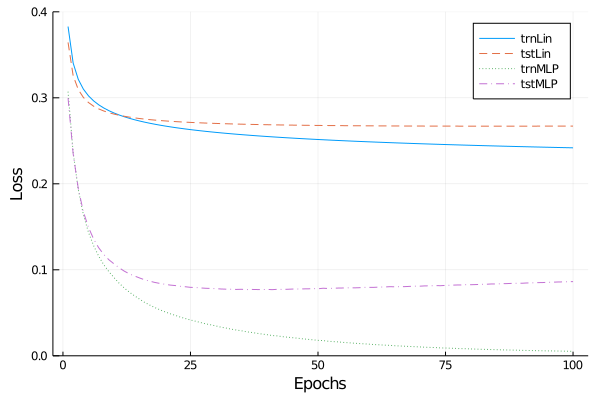

In [16]:
# MLP solves the underfitting problem!  A more serious overfitting problem remains.
plot([lin1[1,:], lin1[2,:], mlp2[1,:], mlp2[2,:]], ylim=(0.0,0.4),
     labels=["trnLin" "tstLin" "trnMLP" "tstMLP"], xlabel="Epochs", ylabel="Loss")

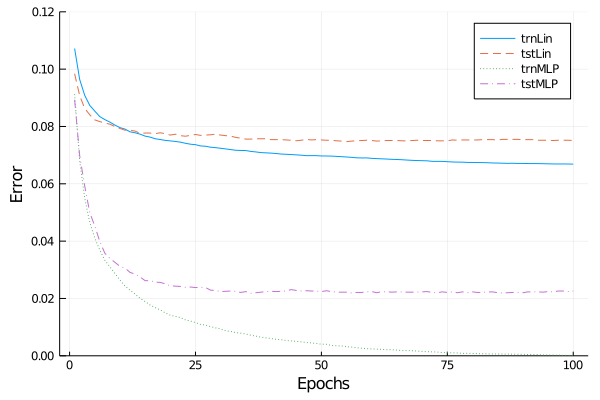

In [17]:
# Test error improves from 7.5% to 2.5%!
plot([lin1[3,:], lin1[4,:], mlp2[3,:], mlp2[4,:]], ylim=(0.0,0.12),
    labels=["trnLin" "tstLin" "trnMLP" "tstMLP"], xlabel="Epochs",ylabel="Error")  

## MLP with L1/L2 regularization

In [18]:
# We add two new fields for L1 and L2 regularization
struct Chain2
    layers; λ1; λ2
    Chain2(layers...; λ1=0, λ2=0) = new(layers, λ1, λ2)
end

# The prediction and average loss do not change
(c::Chain2)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain2)(d::Data) = mean(c(x,y) for (x,y) in d)

In [19]:
# The loss function penalizes the L1 and/or L2 norms of parameters during training
function (c::Chain2)(x,y)
    loss = nll(c(x),y)
    if training() # Only apply regularization during training, only to weights, not biases.
        c.λ1 != 0 && (loss += c.λ1 * sum(sum(abs, l.w) for l in c.layers))
        c.λ2 != 0 && (loss += c.λ2 * sum(sum(abs2,l.w) for l in c.layers))
    end
    return loss
end

In [20]:
# 1.94e-01  100.00%┣████████████████┫ 60000/60000 [00:57/00:57, 1058.05i/s]
# [0.026522; 0.0802438; 0.00688333; 0.0231]
model = Chain2(Layer1(784,64), Layer1(64,10,identity); λ1=4f-5)
mlp3 = trainresults("mlp113d.jld2", model);

Train from scratch? stdin> n
Float32[0.027542168; 0.08254478; 0.0071; 0.0243]


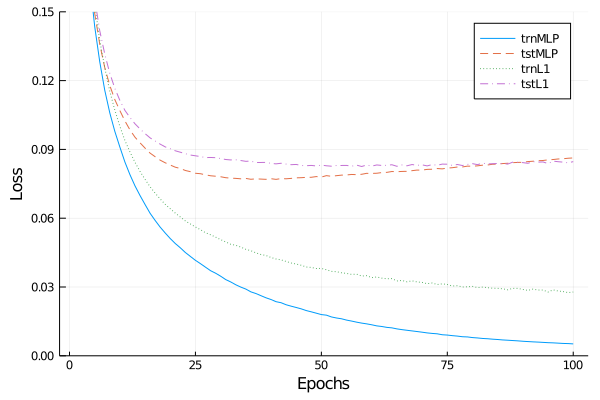

In [21]:
# overfitting less, test loss improves from 0.0841 to 0.0802
plot([mlp2[1,:], mlp2[2,:], mlp3[1,:], mlp3[2,:]], ylim=(0.0,0.15),
     labels=["trnMLP" "tstMLP" "trnL1" "tstL1"],xlabel="Epochs",ylabel="Loss")

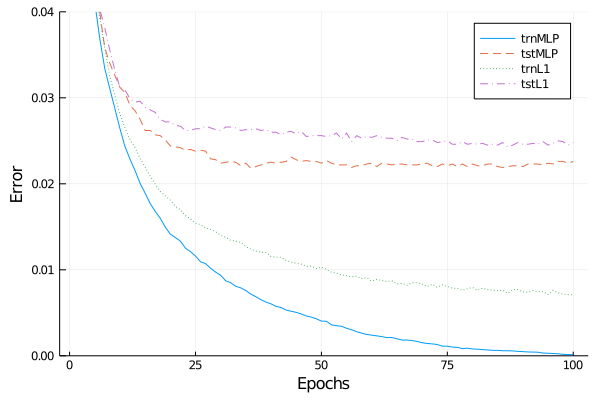

In [22]:
# test error also improves: 0.0243 -> 0.0231
plot([mlp2[3,:], mlp2[4,:], mlp3[3,:], mlp3[4,:]], ylim=(0.0,0.04),
     labels=["trnMLP" "tstMLP" "trnL1" "tstL1"],xlabel="Epochs",ylabel="Error")

## MLP with dropout

In [23]:
@doc dropout

```
dropout(x, p; drop, seed)
```

Given an array `x` and probability `0<=p<=1` return an array `y` in which each element is 0 with probability `p` or `x[i]/(1-p)` with probability `1-p`. Just return `x` if `p==0`, or `drop=false`. By default `drop=true` in a `@diff` context, `drop=false` otherwise.  Specify a non-zero `seed::Number` to set the random number seed for reproducible results. See [(Srivastava et al. 2014)](http://www.jmlr.org/papers/v15/srivastava14a.html) for a reference.


In [24]:
# Dropout is another way to address overfitting
struct Layer2; w; b; f; pdrop; end
Layer2(i::Int,o::Int,f=relu; pdrop=0) = Layer2(param(o,i),param0(o),f,pdrop)
(l::Layer2)(x) = l.f.(l.w * dropout(x,l.pdrop) .+ l.b)

In [25]:
# 1.06e-01  100.00%┣████████████████┫ 60000/60000 [00:53/00:53, 1142.58i/s]
# [0.0144843; 0.067272; 0.00376667; 0.0189]
model = Chain(Layer2(784,64,pdrop=0.2), Layer2(64,10,identity))
mlp4 = trainresults("mlp113e.jld2", model);

Train from scratch? stdin> n
Float32[0.042467445; 0.0909296; 0.013483333; 0.0249]


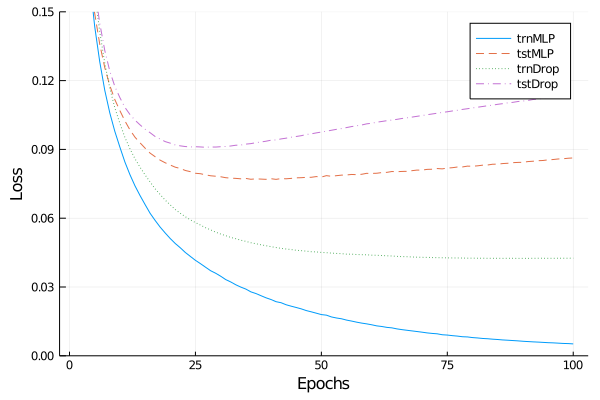

In [26]:
# overfitting less, loss results improve 0.0841 -> 0.0673
plot([mlp2[1,:], mlp2[2,:], mlp4[1,:], mlp4[2,:]], ylim=(0.0,0.15),
     labels=["trnMLP" "tstMLP" "trnDrop" "tstDrop"],xlabel="Epochs",ylabel="Loss")

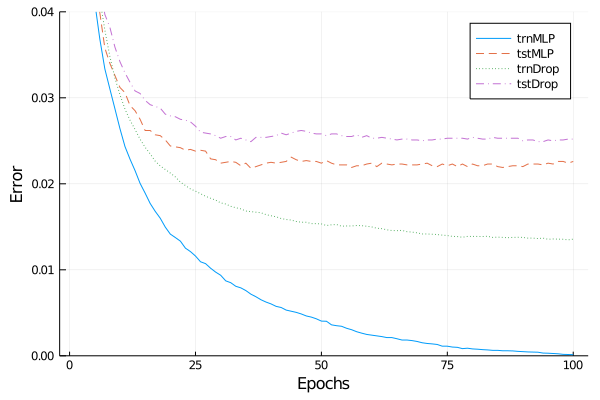

In [27]:
# this time error also improves 0.0243 -> 0.0189
plot([mlp2[3,:], mlp2[4,:], mlp4[3,:], mlp4[4,:]], ylim=(0.0,0.04),
     labels=["trnMLP" "tstMLP" "trnDrop" "tstDrop"],xlabel="Epochs",ylabel="Error")

In [28]:
(mlperr=minimum(mlp2[4,:]),L1err=minimum(mlp3[4,:]),dropouterr=minimum(mlp4[4,:]))

(mlperr = 0.0218f0, L1err = 0.0243f0, dropouterr = 0.0249f0)

In [29]:
(mlploss=minimum(mlp2[2,:]),L1loss=minimum(mlp3[2,:]),dropoutloss=minimum(mlp4[2,:]))

(mlploss = 0.07693735f0, L1loss = 0.08254478f0, dropoutloss = 0.0909296f0)

## MLP with larger hidden layer and dropout

In [30]:
# The current trend is to use models with higher capacity tempered with dropout
# 5.80e-02  100.00%┣████████████████┫ 60000/60000 [00:54/00:54, 1101.25i/s]
# [0.0035497; 0.0479644; 0.0003; 0.0149]
model = Chain(Layer2(784,256,pdrop=0.2), Layer2(256,10,identity))
mlp = trainresults("mlp113f.jld2", model);

Train from scratch? stdin> n
Float32[0.027398968; 0.07152775; 0.008916667; 0.0196]


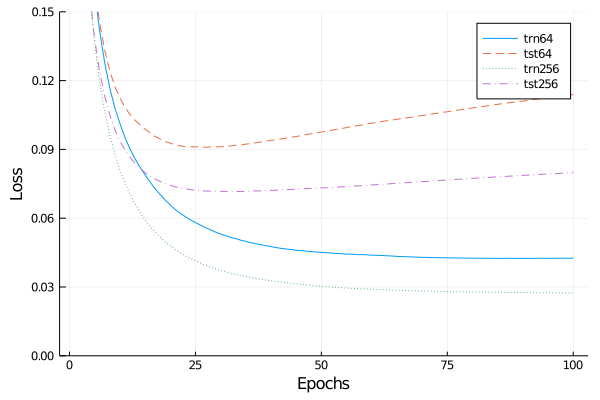

In [31]:
# Both train and test loss is better with the larger model
plot([mlp4[1,:], mlp4[2,:], mlp[1,:], mlp[2,:]],ylim=(0,0.15),
    labels=["trn64" "tst64" "trn256" "tst256"],xlabel="Epochs",ylabel="Loss")

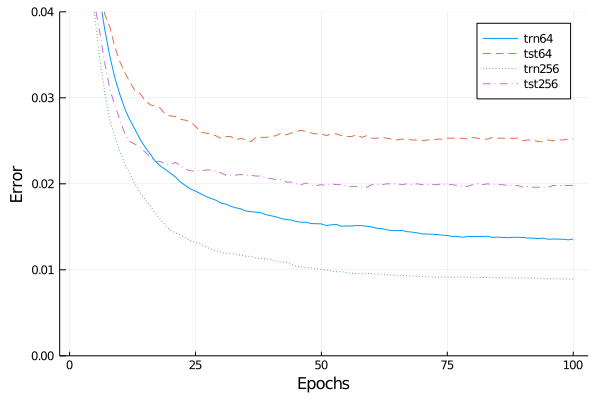

In [32]:
# We are down to 1.5% error.
plot([mlp4[3,:], mlp4[4,:], mlp[3,:], mlp[4,:]],ylim=(0,0.04),
    labels=["trn64" "tst64" "trn256" "tst256"],xlabel="Epochs",ylabel="Error")